# Differential drive robot (a.k.a., the "segbot")

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from scipy import linalg

# This is my own script (it is an interface to the pybullet simulator)
import ae353_segbot

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_segbot)

<module 'ae353_segbot' from 'C:\\Users\\scott\\Documents\\Jupyter\\ae353-sp21\\projects\\02_segbot\\ae353_segbot.py'>

Create an instance of the robot simulator. This will open a window in which you should see the segbot.

There are three optional parameters:

* `damping` is the coefficient of viscous friction at each wheel joint (the default value is `0.`)
* `dt` is the length of each time step in the simulator (the default value is `0.01`)
* `display` is a flag that says whether or not to open the GUI (the default value is `True`)

The `display` parameter, in particular, is likely to be of use to you. If you set `display=True`, then you will run the simulator in real-time with a GUI. If you set `display=False`, then you will run the simulator as fast as possible (faster than real-time) without a GUI. This is convenient when all you want is the data.

**NOTE:** it is still necessary to reset the kernel (see the "Kernel" menu above) before creating a new instance of the robot simulator, even when running without a GUI - if you don't, then you'll notice that simulation slows way down.

In [2]:
# Dimensions of chassis
dx = 0.4
dy = 0.6
dz = 0.8

# Distance between axle and COM of chassis
h = 0.3

# Half-distance between wheels
a = 0.7 / 2

# Mass of chassis
mb = 12.

# MOI of chassis
Jbx = (mb / 12) * (dy**2 + dz**2)
Jby = (mb / 12) * (dx**2 + dz**2)
Jbz = (mb / 12) * (dx**2 + dy**2)

# Radius of each wheel
r = 0.325

# Width of each wheel
hw = 0.075

# Mass of each wheel
mw = 1.2

# MOI of each wheel
Jw = (mw / 2) * r**2
Jwt = (mw / 12) * (3 * r**2 + hw**2)

# Total mass
m = mb + 2 * mw

# Total MOI
Jx = Jbx + 2 * Jwt
Jy = Jby
Jz = Jbz + 2 * Jwt

# Acceleration of gravity
g = 9.81

In [3]:
# Dimensions
h = sym.nsimplify(h)
a = sym.nsimplify(a)
r = sym.nsimplify(r)

# Masses
mb = sym.nsimplify(mb)
mw = sym.nsimplify(mw)
m = sym.nsimplify(m)

# MOIs
Jx = sym.nsimplify(Jx)
Jy = sym.nsimplify(Jy)
Jz = sym.nsimplify(Jz)
Jw = sym.nsimplify(Jw)
Jwt = sym.nsimplify(Jwt)

# Gravity
g = sym.nsimplify(g)

In [4]:
(e_l,
 e_h,
 v,
 w,
 theta,
 theta_dot,
 tau_l,
 tau_r) = sym.symbols('e_l, e_h, v, w, theta, thetadot, tau_l, tau_r', real=True)

In [5]:
M = sym.Matrix([[m + 2 * Jw / r**2, 0, mb * h * sym.cos(theta)],
                [0, (Jx + mb * h**2) * sym.sin(theta)**2 + Jz * sym.cos(theta)**2 + (2 * Jw * a**2 / r**2) + 2 * mw * a**2, 0],
                [mb * h * sym.cos(theta), 0, Jy * mb * h**2]])
N = sym.Matrix([[mb * h * (w**2 + theta_dot**2) * sym.sin(theta)],
                [-2 * (Jx - Jz + m * h**2) * sym.cos(theta) * sym.sin(theta) * w * theta_dot - mb * h * sym.sin(theta) * v * w],
                [(Jx - Jz + mb * h**2) * sym.cos(theta) * sym.sin(theta) * w**2 + mb * g * h * sym.sin(theta)]])
R = sym.Matrix([[1 / r, 1 / r],
                [-a / r, a / r],
                [-1, -1]])
s = sym.simplify(M.inv() * (N + R * sym.Matrix([[tau_l], [tau_r]])))

In [6]:
ff = sym.Matrix([s])

In [7]:
f = sym.Matrix([[v*sym.sin(e_h)],
     [w],
     [-(2400*tau_l + 2400*tau_r + 2808*(theta_dot**2 + w**2)*sym.sin(theta) + 13*(250*tau_l + 250*tau_r - 195*w**2*sym.sin(2*theta) - 8829*sym.sin(theta))*sym.cos(theta))/(11700*sym.cos(theta)**2 - 12168)], 
     [32*(-875*tau_l + 875*tau_r - 1443*theta_dot*w*sym.sin(2*theta) - 2925*v*w*sym.sin(theta))/(13*(3120*sym.sin(theta)**2 + 2051))], 
     [theta_dot],
     [(42250*tau_l + 42250*tau_r - 32955*w**2*sym.sin(2*theta) + 300*(100*tau_l + 100*tau_r + 117*(theta_dot**2 + w**2)*sym.sin(theta))*sym.cos(theta) - 1492101*sym.sin(theta))/(1404*(25*sym.cos(theta)**2 - 26))]])

In [8]:
robot = ae353_segbot.RobotSimulator(damping=0., dt=0.01, display=True)

Define and create an instance of the robot controller. By default, it chooses to apply zero torque both to the gimbal and to the rotor. Modify the `run` function - or anything else in the class definition - to make the controller behave differently.

In [9]:
e_le = -0.4
e_he = 0.
v_e = 3.
w_e = 0.
theta_e = 0.
theta_dot_e = 0.
tau_le = 0.
tau_re = 0.

In [10]:
A_num = sym.lambdify((e_l, e_h, v, w, theta, theta_dot, tau_l, tau_r),f.jacobian([e_l, e_h, v, w, theta, theta_dot]))
A = A_num(e_le, e_he, v_e, w_e, theta_e, theta_dot_e, tau_le, tau_re)
B_num = sym.lambdify((theta),f.jacobian([tau_l, tau_r]))
B = B_num(theta_e)

In [11]:
W = B
n = A.shape[0]
for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    W = np.block([W, col])
rank = np.linalg.matrix_rank(W)
if rank == n:
    print('Yes')
else:
    print('No')

Yes


In [12]:
Q = np.eye(6)
R = np.eye(2)

x0 = np.array([[e_le],[e_he],[v_e],[w_e],[theta_e],[theta_dot_e]])

P = linalg.solve_continuous_are(A, B, Q, R)
K = linalg.inv(R) @  B.T @ P

In [13]:
class RobotController:
    def __init__(self, dt=0.01):
        self.dt = dt    
        
        self.e_le = e_le
        self.e_he = e_he
        self.v_e = v_e
        self.w_e = w_e
        self.theta_e = theta_e
        self.theta_dot_e = theta_dot_e
        
        # Assign K to class
        self.K = K
        
    def run(self, lateral_error, heading_error, forward_speed, turning_rate, pitch_angle, pitch_rate):
        
        x = np.array([[lateral_error - self.e_le], [heading_error - self.e_he], [forward_speed - self.v_e], [turning_rate - self.w_e], [pitch_angle - self.theta_e], [pitch_rate - self.theta_dot_e]])
        u = -self.K @ x

        # Assign torques from input u
        tau_left = u[0, 0]
        tau_right = u[1, 0]
                
        return tau_left, tau_right
controller = RobotController(dt=robot.dt)

Run the simulation. It is a loop. At each iteration, we:
* get sensor measurements
* choose actuator commands
* go forward one time step

We also log data so that we can plot it later, if we want.

In [14]:
# Restore the simulation to its initial state
robot.reset(turn_left=False,            # does the robot turn left or right around the track
            ground_pitch=0.,            # angle that the track is sloped (rad)
            initial_speed=0.,           # initial forward speed of segbot (m/s)
            initial_lateral_error=0.,   # initial lateral error of segbot (m)
            initial_heading_error=0.,   # initial heading error of segbot (rad)
            initial_pitch=0.)           # initial pitch angle of chassis (rad)

# Choose a camera view
robot.camera_sideview()
# robot.camera_topview()
# robot.camera_chaseview(yaw=180.)
# robot.camera_chaseview(yaw=90.)

# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 50.
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'lateral_error': np.empty(num_steps, dtype=float),
    'heading_error': np.empty(num_steps, dtype=float),
    'forward_speed': np.empty(num_steps, dtype=float),
    'turning_rate': np.empty(num_steps, dtype=float),
    'pitch_angle': np.empty(num_steps, dtype=float),
    'pitch_rate': np.empty(num_steps, dtype=float),
    'tau_left_command': np.empty(num_steps, dtype=float),
    'tau_right_command': np.empty(num_steps, dtype=float),
    'tau_left': np.empty(num_steps, dtype=float),
    'tau_right': np.empty(num_steps, dtype=float),
}

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    (lateral_error,
     heading_error,
     forward_speed,
     turning_rate,
     pitch_angle,
     pitch_rate) = robot.get_sensor_measurements()
    
    # Choose the actuator command (by running the controller)
    tau_left_command, tau_right_command = controller.run(lateral_error,
                                                         heading_error,
                                                         forward_speed,
                                                         turning_rate,
                                                         pitch_angle,
                                                         pitch_rate)
    
    # Apply the actuator commands
    tau_left, tau_right = robot.set_actuator_commands(tau_left_command, tau_right_command)
    
    # Log the data from this time step
    data['t'][step] = t
    data['lateral_error'][step] = lateral_error
    data['heading_error'][step] = heading_error
    data['forward_speed'][step] = forward_speed
    data['turning_rate'][step] = turning_rate
    data['pitch_angle'][step] = pitch_angle
    data['pitch_rate'][step] = pitch_rate
    data['tau_left_command'][step] = tau_left_command
    data['tau_right_command'][step] = tau_right_command
    data['tau_left'][step] = tau_left
    data['tau_right'][step] = tau_right
    
    # Simulate one time step
    robot.step(t=(start_time + (robot.dt * (step + 1))))

An example of how to plot results. This is just an example!

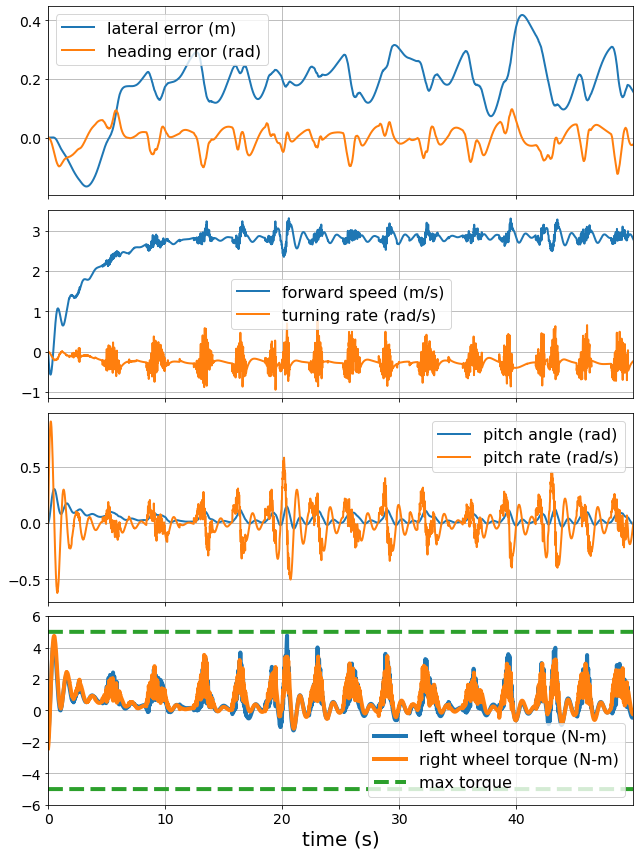

In [15]:
# Create a figure with four subplots, all of which share the same x-axis
fig, ax = plt.subplots(4, 1, figsize=(9, 12), sharex=True)

# First subplot
ax[0].plot(data['t'], data['lateral_error'], label='lateral error (m)', linewidth=2)
ax[0].plot(data['t'], data['heading_error'], label='heading error (rad)', linewidth=2)
ax[0].grid()
ax[0].legend(fontsize=16)
ax[0].tick_params(labelsize=14)

# Second subplot
ax[1].plot(data['t'], data['forward_speed'], label='forward speed (m/s)', linewidth=2)
ax[1].plot(data['t'], data['turning_rate'], label='turning rate (rad/s)', linewidth=2)
ax[1].grid()
ax[1].legend(fontsize=16)
ax[1].tick_params(labelsize=14)

# Third subplot
ax[2].plot(data['t'], data['pitch_angle'], label='pitch angle (rad)', linewidth=2)
ax[2].plot(data['t'], data['pitch_rate'], label='pitch rate (rad/s)', linewidth=2)
ax[2].grid()
ax[2].legend(fontsize=16)
ax[2].tick_params(labelsize=14)

# Fourth subplot
ax[3].plot(data['t'], data['tau_left'], label='left wheel torque (N-m)', linewidth=4)
ax[3].plot(data['t'], data['tau_right'], label='right wheel torque (N-m)', linewidth=4)
ax[3].plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max torque', linewidth=4, color='C2')
ax[3].plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C2')
ax[3].grid()
ax[3].legend(fontsize=16)
ax[3].tick_params(labelsize=14)
ax[3].set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

# Set x-axis properties (only need to do this on the fourth
# subplot since all four subplots share the same x-axis)
ax[3].set_xlabel('time (s)', fontsize=20)
ax[3].set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()